In [24]:
#import important functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RANSACRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix,roc_auc_score,classification_report
from sklearn.model_selection import StratifiedKFold, KFold,ShuffleSplit
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

###  Classification Using Logistic Regression, SVM and Random Forrest ###

#### This trains the model with all the training data and uses the test data to find the test performance ####

Each classifers are trained and tested for RGB, HSV and Lab Color Spaces. Here, the mean color values of the images are used as input features.

        

To obtain consistent channel values across images captured at different conditions. Both the Sample Zone and Reference are used for input features. This somwhat rejects the inconsitency introduced due to illumination variance. The notion is both sample and reference zone will have same effect of illumination, so their difference will result in color constancy.

In [36]:
### loads the xlsx file containing mean RGB data and returns the difference value of each RGB channel,i.e Sample - Reference

def load_RGB():
    # load RGB channel data
    data= pd.read_csv('data/mean_value_data/mean_pixel_RGB_2400.csv')
    
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)
    
    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
   

    # in each channel, calculate "sample-reference" values
    data['Diff_Red']= data['RedSample']-data['RedReference']
    data['Diff_Green']= data['GreenSample']-data['GreenReference']
    data['Diff_Blue']= data['BlueSample']-data['BlueReference']

    Diff_values= data[['Diff_Red','Diff_Green','Diff_Blue']]
    Values= data[['BlueReference','BlueSample','GreenReference','GreenSample','RedReference','RedSample']]
    Values_sample= data[['BlueSample','GreenSample','RedSample']]
    return Label, Values.values


In [37]:
#### loads the xlsx file containing mean HSV values and returns the difference of values, i.e, Sample- Reference of each value
def load_HSV():
    # load HSV channel data
    data= pd.read_csv('data/mean_value_data/mean_pixel_HSV_2400.csv')
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)

    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
    

    # in each channel, calculate "sample-reference" values ,here we have used sample- refernce instead of reference - sample. The relation is same, just the sign is reversed.
    # This is done just to obtain the position value of H value.

    data['Diff_H']= data['HSample']-data['HReference']
    data['Diff_S']= data['SSample']-data['SReference']
    data['Diff_V']= data['VSample']-data['VReference']

    Diff_values= data[['Diff_H','Diff_S','Diff_V']]
    Values= data[['HReference','HSample','SReference','SSample','VReference','VSample']]
    Values_sample= data[['HSample','SSample','VSample']]

    return Label, Values.values

In [38]:
#### loads the xlsx file containing mean LAB values and returns the difference, i.e,  Reference- sample of each value
def load_LAB():
    # load Lab channel data
    data= pd.read_csv('data/mean_value_data/mean_pixel_LAB_2400.csv')
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)

    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
    


    # in each channel, calculate "reference-sample" values ,here we have used reference- sample instead of sample - reference. The relation is same, just the sign is reversed.
    # This is done just to obtain the position differnces

    data['Diff_L']= data['LReference']-data['LSample']
    data['Diff_a']= data['aReference']-data['aSample']
    data['Diff_b']= data['bReference']-data['bSample']

    Diff_values= data[['Diff_L','Diff_a','Diff_b']]
    Values = data [['LReference','LSample','aReference','aSample','bReference','bSample']]
    Values_sample= data[['LSample','aSample','bSample']]

    return Label, Values.values

### Plot Confusion Matrix to Visualize### 


In [41]:
#### function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    #transpose the matrix to make x-axis True Class and Y-axis Predicted Class
    cm= np.transpose(cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           
           #here we are not printing the title
           #title=title,
           xlabel='True label',
           ylabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig,ax


### Logistic Regression ###

In [42]:
##### this function classifies the data using the logistic function and returns the predicition value, here stratified k-fold validation has been used 
def Logistic_Regression( Labels,Values,colorspace ="RGB"):
  
    


    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info) 
    accuracy =[]
    i=1


    for train_index, test_index in kf.split(Values,Labels):
        lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=42)
        #print (Values[train_index].shape)
        lr.fit(Values[train_index],Labels[train_index]) ## [:,0] is used to pass only 1D array to eliminate warning message,however, sklearn can self-interpret if 2D given, but shows warning
        Accuracy= accuracy_score(Labels[test_index],lr.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],lr.predict(Values[test_index]), target_names=["1","2","3"]))
        fig,ax= plot_confusion_matrix(Labels[test_index],lr.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, Logistic Regression '+colorspace)
        plt.show()
        filename = "Logistic Reg Confusion Matrix Mean"+colorspace+", split"+str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

### SVM ###



In [43]:
###### this Function uses SVM classifer, stratified k-fold validation is used to test validation accuarcy
def SVM_Classifier(Labels,Values,colorspace ="RGB"):
    


    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info)
    accuracy =[]
    i=1

    for train_index, test_index in kf.split(Values,Labels):
        clf = SVC(kernel='linear',gamma='scale',random_state=42)
    
        clf.fit(Values[train_index],Labels[train_index]) #### [:,0] is used to pass only 1D array to eliminate warning message,however, sklearn can self-interpret if 2D given, but shows warning
        Accuracy= accuracy_score(Labels[test_index],clf.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],clf.predict(Values[test_index]), target_names=["1","2","3"]))
        fig,ax = plot_confusion_matrix(Labels[test_index],clf.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, SVM '+colorspace)
        plt.show()
        filename = "SVM Confusion Matrix Mean" +colorspace+", split" +str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

### Random Forest###

In [44]:
###### this Function uses Random Forrest classifer, stratified k-fold validation is used to test validation accuarcy
def Random_Forrest(Labels,Values,colorspace ="RGB"):
  
    



    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info) 
    accuracy = []
    i=1

    for train_index, test_index in kf.split(Values,Labels):
        clf = RandomForestClassifier(n_estimators=1000, max_depth= None,random_state=42)

        clf.fit(Values[train_index],Labels[train_index]) #### [:,0] is used to pass only 1D array to eliminate warning message,however, sklearn can self-interpret if 2D given, but shows warning
        Accuracy= accuracy_score(Labels[test_index],clf.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],clf.predict(Values[test_index]), target_names=["1","2","3"]))
        fig, ax= plot_confusion_matrix(Labels[test_index],clf.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, Random Forrest '+colorspace)
        plt.show()
        filename = "Random Forest Confusion Matrix Mean " +colorspace+", split"+str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

In [45]:
def save_csv(accuracy_list,csv_file,remarks):
    avg= np.mean(accuracy_list)
    df_list = accuracy_list.copy()
    df_list.extend([avg,remarks])
    print (df_list)
    df=pd.DataFrame(columns=['split1', 'split2','split3','split4','split5','avg_accuracy','remarks'], data=[df_list])
    print (df)
    with open(csv_file, 'a') as f:
        df.to_csv(f, index= False, header=f.tell()==0)
    

### Train and Test Each Classifers for Different Input Features###


### Train and Test Logistic Regression ###

For RGB color space
5
For Split: 1 , Accuracy Score:  0.951271186440678
              precision    recall  f1-score   support

           1       0.94      0.99      0.97       144
           2       0.96      0.92      0.94       192
           3       0.95      0.96      0.95       136

   micro avg       0.95      0.95      0.95       472
   macro avg       0.95      0.96      0.95       472
weighted avg       0.95      0.95      0.95       472

Confusion matrix, without normalization


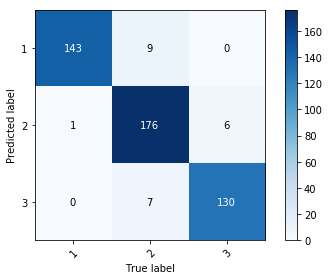

For Split: 2 , Accuracy Score:  0.9382978723404255
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       143
           2       0.91      0.94      0.93       192
           3       0.96      0.93      0.95       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


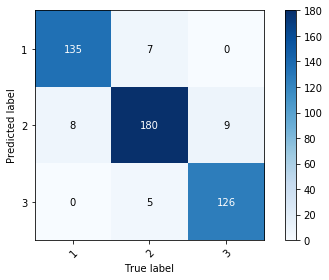

For Split: 3 , Accuracy Score:  0.951063829787234
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       143
           2       0.95      0.93      0.94       192
           3       0.92      0.96      0.94       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


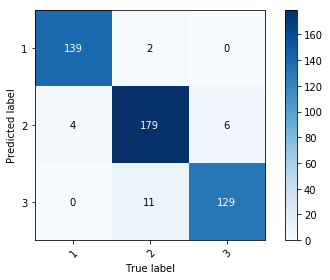

For Split: 4 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.98      0.96      0.97       143
           2       0.93      0.94      0.94       192
           3       0.93      0.95      0.94       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


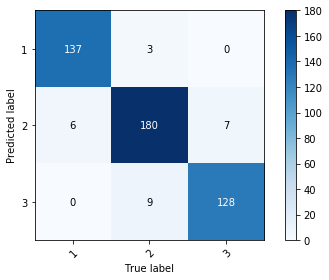

For Split: 5 , Accuracy Score:  0.9340425531914893
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       143
           2       0.92      0.92      0.92       192
           3       0.94      0.90      0.92       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.93      0.94       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


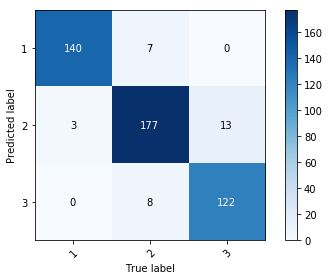

Mean Accuracy 0.9442967904796248
[0.951271186440678, 0.9382978723404255, 0.951063829787234, 0.9468085106382979, 0.9340425531914893, 0.9442967904796248, 'RGB,Logistic Regression']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.951271  0.938298  0.951064  0.946809  0.934043      0.944297   

                   remarks  
0  RGB,Logistic Regression  
For LAB color space
5
For Split: 1 , Accuracy Score:  0.9491525423728814
              precision    recall  f1-score   support

           1       0.94      0.99      0.97       144
           2       0.96      0.91      0.94       192
           3       0.94      0.96      0.95       136

   micro avg       0.95      0.95      0.95       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.95      0.95      0.95       472

Confusion matrix, without normalization


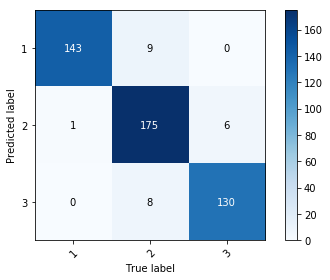

For Split: 2 , Accuracy Score:  0.9425531914893617
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       143
           2       0.92      0.94      0.93       192
           3       0.97      0.93      0.95       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.95      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


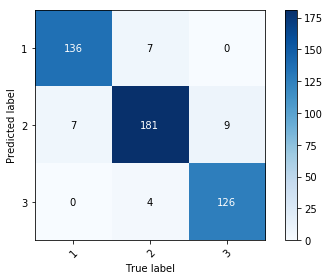

For Split: 3 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.97      0.97      0.97       143
           2       0.94      0.92      0.93       192
           3       0.93      0.95      0.94       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.95      0.95       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


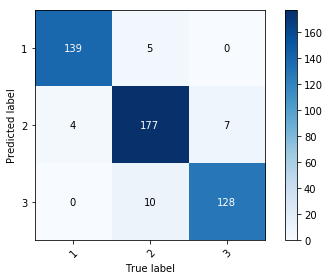

For Split: 4 , Accuracy Score:  0.9319148936170213
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       143
           2       0.91      0.93      0.92       192
           3       0.94      0.93      0.94       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


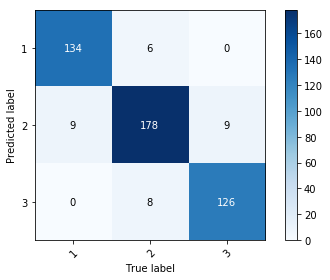

For Split: 5 , Accuracy Score:  0.9276595744680851
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       143
           2       0.91      0.91      0.91       192
           3       0.94      0.90      0.92       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


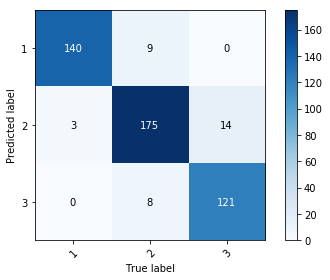

Mean Accuracy 0.9391922106022358
[0.9491525423728814, 0.9425531914893617, 0.9446808510638298, 0.9319148936170213, 0.9276595744680851, 0.9391922106022358, 'LAB,Logistic Regression']
     split1    split2    split3    split4   split5  avg_accuracy  \
0  0.949153  0.942553  0.944681  0.931915  0.92766      0.939192   

                   remarks  
0  LAB,Logistic Regression  
For HSV color space
5
For Split: 1 , Accuracy Score:  0.9364406779661016
              precision    recall  f1-score   support

           1       0.92      0.98      0.95       144
           2       0.95      0.89      0.92       192
           3       0.94      0.96      0.95       136

   micro avg       0.94      0.94      0.94       472
   macro avg       0.94      0.94      0.94       472
weighted avg       0.94      0.94      0.94       472

Confusion matrix, without normalization


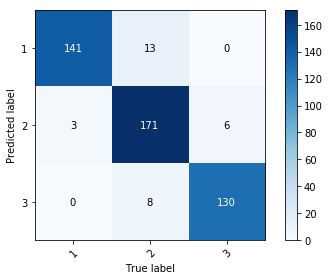

For Split: 2 , Accuracy Score:  0.9340425531914893
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       143
           2       0.91      0.93      0.92       192
           3       0.95      0.93      0.94       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.93      0.94       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


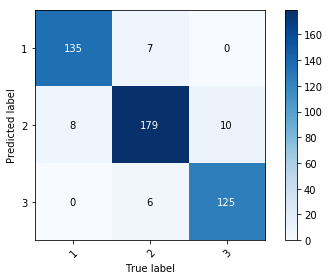

For Split: 3 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       143
           2       0.95      0.92      0.93       192
           3       0.91      0.95      0.93       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.95      0.95       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


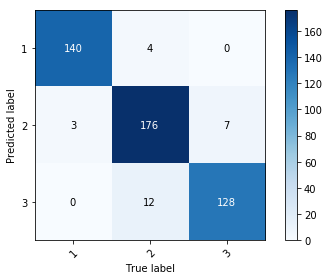

For Split: 4 , Accuracy Score:  0.9276595744680851
              precision    recall  f1-score   support

           1       0.94      0.93      0.94       143
           2       0.91      0.92      0.91       192
           3       0.94      0.94      0.94       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


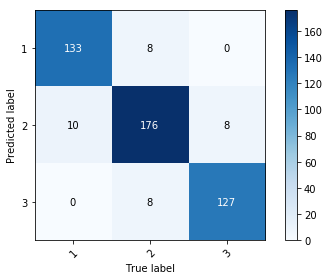

For Split: 5 , Accuracy Score:  0.9212765957446809
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       143
           2       0.91      0.90      0.90       192
           3       0.94      0.90      0.92       135

   micro avg       0.92      0.92      0.92       470
   macro avg       0.92      0.92      0.92       470
weighted avg       0.92      0.92      0.92       470

Confusion matrix, without normalization


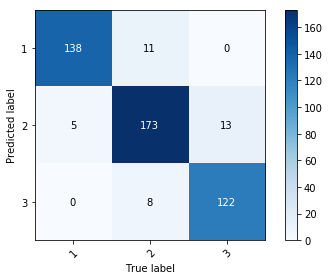

Mean Accuracy 0.9328200504868374
[0.9364406779661016, 0.9340425531914893, 0.9446808510638298, 0.9276595744680851, 0.9212765957446809, 0.9328200504868374, 'HSV,Logistic Regression']
     split1    split2    split3   split4    split5  avg_accuracy  \
0  0.936441  0.934043  0.944681  0.92766  0.921277       0.93282   

                   remarks  
0  HSV,Logistic Regression  


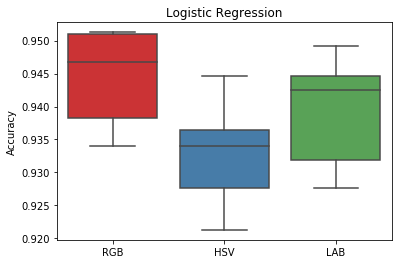

In [46]:
print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB =Logistic_Regression(L, V,colorspace ="RGB")
print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))
save_csv(accuracy_score_list_RGB,'cross_validation_mean_value.csv','RGB,Logistic Regression')

print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB = Logistic_Regression(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_mean_value.csv','LAB,Logistic Regression')

print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV =Logistic_Regression(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_mean_value.csv','HSV,Logistic Regression')

ax = sns.boxplot(x=['RGB','HSV','LAB'], y=[accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set(title= 'Logistic Regression' ,ylabel='Accuracy')
plt.show()
filename = "bax_plot_mean_logistic_regression.png"
fig = ax.get_figure()
fig.savefig(filename)



### Train and Test SVM ###

For RGB color space
5
For Split: 1 , Accuracy Score:  0.951271186440678
              precision    recall  f1-score   support

           1       0.94      0.99      0.97       144
           2       0.96      0.92      0.94       192
           3       0.95      0.96      0.95       136

   micro avg       0.95      0.95      0.95       472
   macro avg       0.95      0.96      0.95       472
weighted avg       0.95      0.95      0.95       472

Confusion matrix, without normalization


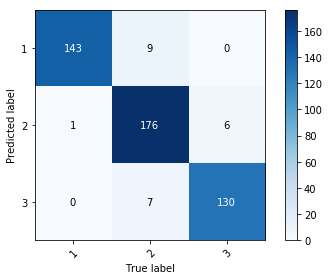

For Split: 2 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       143
           2       0.93      0.94      0.94       192
           3       0.97      0.93      0.95       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


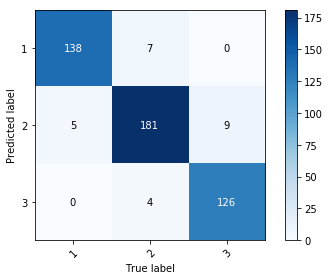

For Split: 3 , Accuracy Score:  0.9404255319148936
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       143
           2       0.95      0.91      0.93       192
           3       0.92      0.95      0.93       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


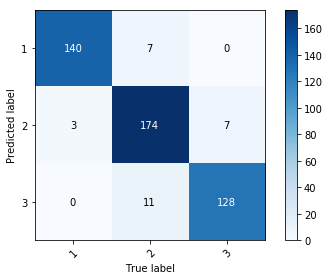

For Split: 4 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       143
           2       0.92      0.94      0.93       192
           3       0.95      0.94      0.94       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.95      0.94      0.95       470
weighted avg       0.95      0.94      0.94       470

Confusion matrix, without normalization


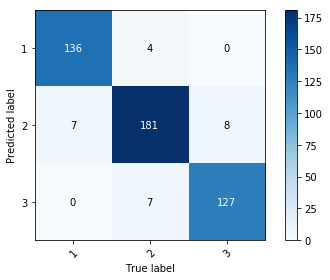

For Split: 5 , Accuracy Score:  0.9276595744680851
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       143
           2       0.90      0.93      0.91       192
           3       0.95      0.87      0.91       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


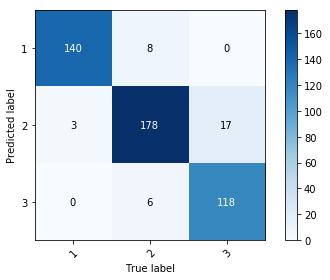

Mean Accuracy 0.942169130905157
[0.951271186440678, 0.9468085106382979, 0.9404255319148936, 0.9446808510638298, 0.9276595744680851, 0.942169130905157, 'RGB,SVM']
     split1    split2    split3    split4   split5  avg_accuracy  remarks
0  0.951271  0.946809  0.940426  0.944681  0.92766      0.942169  RGB,SVM
SVM
For LAB color space
5
For Split: 1 , Accuracy Score:  0.9449152542372882
              precision    recall  f1-score   support

           1       0.94      0.99      0.97       144
           2       0.96      0.91      0.93       192
           3       0.93      0.95      0.94       136

   micro avg       0.94      0.94      0.94       472
   macro avg       0.94      0.95      0.95       472
weighted avg       0.95      0.94      0.94       472

Confusion matrix, without normalization


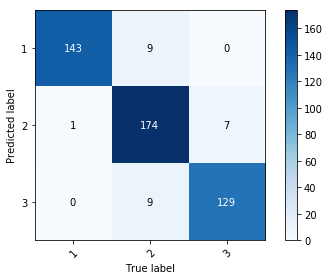

For Split: 2 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       143
           2       0.94      0.93      0.93       192
           3       0.95      0.94      0.95       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


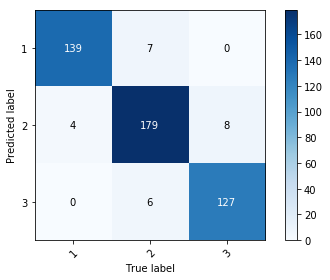

For Split: 3 , Accuracy Score:  0.948936170212766
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       143
           2       0.95      0.92      0.94       192
           3       0.93      0.95      0.94       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


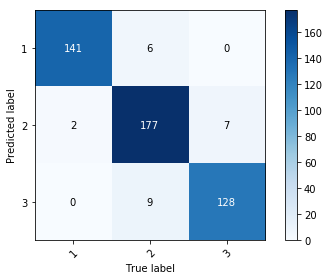

For Split: 4 , Accuracy Score:  0.9340425531914893
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       143
           2       0.91      0.93      0.92       192
           3       0.95      0.93      0.94       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.93      0.94       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


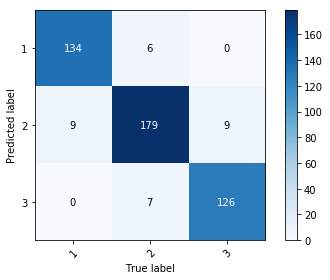

For Split: 5 , Accuracy Score:  0.9276595744680851
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       143
           2       0.90      0.92      0.91       192
           3       0.95      0.88      0.92       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


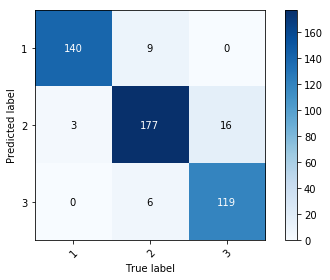

Mean Accuracy 0.9404724125495854
[0.9449152542372882, 0.9468085106382979, 0.948936170212766, 0.9340425531914893, 0.9276595744680851, 0.9404724125495854, 'LAB,SVM']
     split1    split2    split3    split4   split5  avg_accuracy  remarks
0  0.944915  0.946809  0.948936  0.934043  0.92766      0.940472  LAB,SVM
For HSV color space
5
For Split: 1 , Accuracy Score:  0.934322033898305
              precision    recall  f1-score   support

           1       0.92      0.98      0.95       144
           2       0.94      0.89      0.92       192
           3       0.94      0.95      0.95       136

   micro avg       0.93      0.93      0.93       472
   macro avg       0.93      0.94      0.94       472
weighted avg       0.93      0.93      0.93       472

Confusion matrix, without normalization


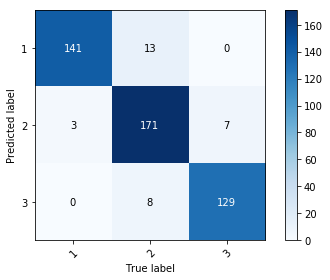

For Split: 2 , Accuracy Score:  0.9404255319148936
              precision    recall  f1-score   support

           1       0.95      0.96      0.95       143
           2       0.92      0.94      0.93       192
           3       0.96      0.93      0.94       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


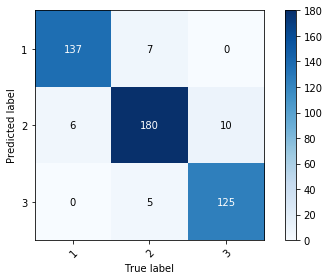

For Split: 3 , Accuracy Score:  0.9382978723404255
              precision    recall  f1-score   support

           1       0.93      0.99      0.96       143
           2       0.96      0.89      0.92       192
           3       0.92      0.95      0.93       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


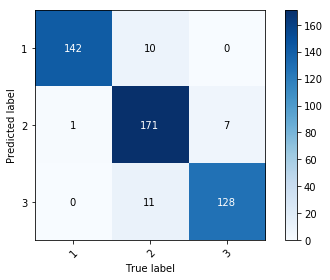

For Split: 4 , Accuracy Score:  0.925531914893617
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       143
           2       0.91      0.91      0.91       192
           3       0.95      0.94      0.94       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


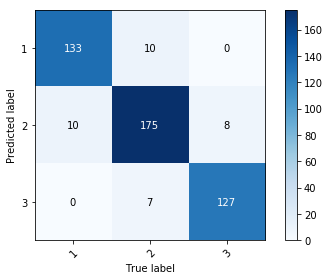

For Split: 5 , Accuracy Score:  0.9170212765957447
              precision    recall  f1-score   support

           1       0.92      0.97      0.94       143
           2       0.90      0.90      0.90       192
           3       0.94      0.89      0.92       135

   micro avg       0.92      0.92      0.92       470
   macro avg       0.92      0.92      0.92       470
weighted avg       0.92      0.92      0.92       470

Confusion matrix, without normalization


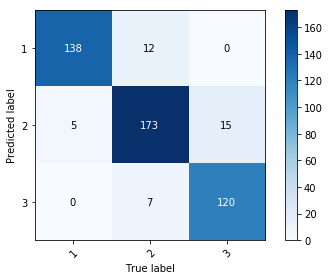

Mean Accuracy 0.9311197259285973
[0.934322033898305, 0.9404255319148936, 0.9382978723404255, 0.925531914893617, 0.9170212765957447, 0.9311197259285973, 'HSV,SVM']
     split1    split2    split3    split4    split5  avg_accuracy  remarks
0  0.934322  0.940426  0.938298  0.925532  0.917021       0.93112  HSV,SVM


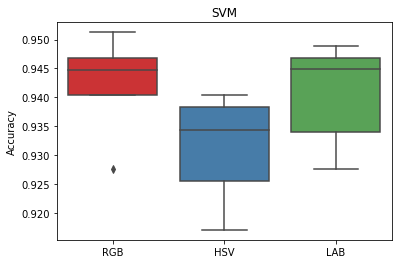

In [47]:

print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB=SVM_Classifier(L, V,colorspace ="RGB")
print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))
save_csv(accuracy_score_list_RGB,'cross_validation_mean_value.csv','RGB,SVM')

print ("SVM")
print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB=SVM_Classifier(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_mean_value.csv','LAB,SVM')

print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV=SVM_Classifier(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_mean_value.csv','HSV,SVM')

ax = sns.boxplot(x=['RGB','HSV','LAB'], y=[accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set(title= 'SVM' ,ylabel='Accuracy')
filename = "bar_plot_mean_SVM.png"
fig = ax.get_figure()
fig.savefig(filename)
plt.show()


### Train and Test Random Forrest ###

For RGB color space
5
For Split: 1 , Accuracy Score:  0.9449152542372882
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       144
           2       0.95      0.92      0.93       192
           3       0.96      0.96      0.96       136

   micro avg       0.94      0.94      0.94       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.95      0.94      0.94       472

Confusion matrix, without normalization


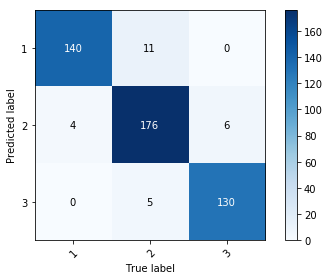

For Split: 2 , Accuracy Score:  0.9276595744680851
              precision    recall  f1-score   support

           1       0.91      0.96      0.93       143
           2       0.92      0.91      0.91       192
           3       0.97      0.93      0.95       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


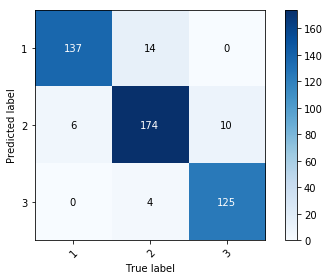

For Split: 3 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       143
           2       0.95      0.92      0.93       192
           3       0.93      0.96      0.95       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.95      0.95       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


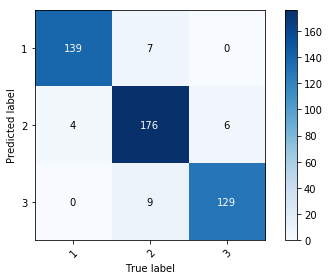

For Split: 4 , Accuracy Score:  0.9234042553191489
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       143
           2       0.91      0.90      0.91       192
           3       0.93      0.96      0.95       135

   micro avg       0.92      0.92      0.92       470
   macro avg       0.92      0.93      0.93       470
weighted avg       0.92      0.92      0.92       470

Confusion matrix, without normalization


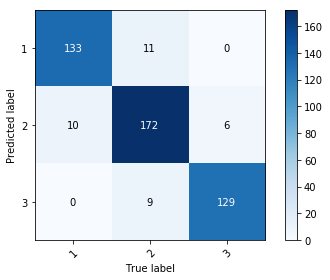

For Split: 5 , Accuracy Score:  0.9212765957446809
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       143
           2       0.91      0.90      0.90       192
           3       0.94      0.90      0.92       135

   micro avg       0.92      0.92      0.92       470
   macro avg       0.92      0.92      0.92       470
weighted avg       0.92      0.92      0.92       470

Confusion matrix, without normalization


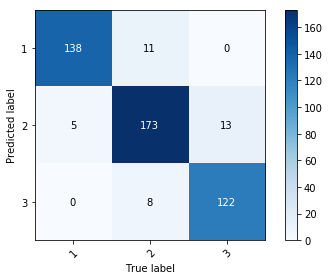

Mean Accuracy 0.9323873061666067
[0.9449152542372882, 0.9276595744680851, 0.9446808510638298, 0.9234042553191489, 0.9212765957446809, 0.9323873061666067, 'RGB,Random Forest']
     split1   split2    split3    split4    split5  avg_accuracy  \
0  0.944915  0.92766  0.944681  0.923404  0.921277      0.932387   

             remarks  
0  RGB,Random Forest  
Random Forrest
For LAB color space
5
For Split: 1 , Accuracy Score:  0.951271186440678
              precision    recall  f1-score   support

           1       0.93      0.96      0.95       144
           2       0.95      0.93      0.94       192
           3       0.98      0.97      0.97       136

   micro avg       0.95      0.95      0.95       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.95      0.95      0.95       472

Confusion matrix, without normalization


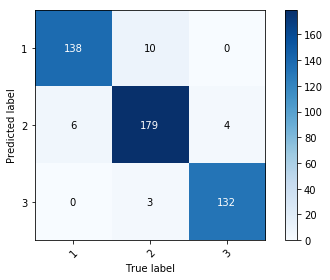

For Split: 2 , Accuracy Score:  0.9553191489361702
              precision    recall  f1-score   support

           1       0.96      0.95      0.95       143
           2       0.94      0.95      0.95       192
           3       0.98      0.96      0.97       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


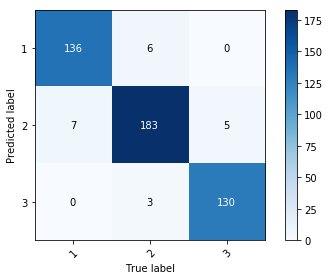

For Split: 3 , Accuracy Score:  0.9319148936170213
              precision    recall  f1-score   support

           1       0.94      0.92      0.93       143
           2       0.91      0.92      0.92       192
           3       0.96      0.96      0.96       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


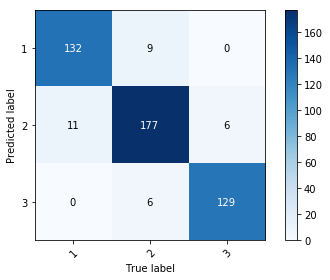

For Split: 4 , Accuracy Score:  0.9340425531914893
              precision    recall  f1-score   support

           1       0.94      0.91      0.93       143
           2       0.90      0.94      0.92       192
           3       0.98      0.95      0.96       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.93      0.94       470
weighted avg       0.94      0.93      0.93       470

Confusion matrix, without normalization


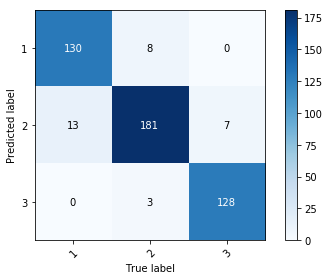

For Split: 5 , Accuracy Score:  0.9340425531914893
              precision    recall  f1-score   support

           1       0.93      0.99      0.96       143
           2       0.92      0.92      0.92       192
           3       0.95      0.90      0.93       135

   micro avg       0.93      0.93      0.93       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.93      0.93      0.93       470

Confusion matrix, without normalization


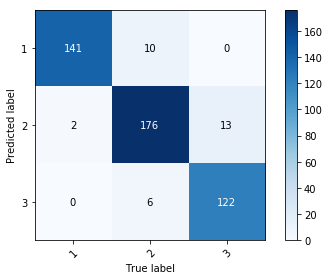

Mean Accuracy 0.9413180670753697
[0.951271186440678, 0.9553191489361702, 0.9319148936170213, 0.9340425531914893, 0.9340425531914893, 0.9413180670753697, 'LAB,Random Forest']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.951271  0.955319  0.931915  0.934043  0.934043      0.941318   

             remarks  
0  LAB,Random Forest  
For HSV color space
5
For Split: 1 , Accuracy Score:  0.9703389830508474
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       144
           2       0.97      0.96      0.96       192
           3       1.00      0.98      0.99       136

   micro avg       0.97      0.97      0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472

Confusion matrix, without normalization


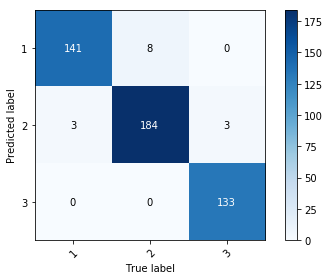

For Split: 2 , Accuracy Score:  0.9574468085106383
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       143
           2       0.93      0.97      0.95       192
           3       1.00      0.96      0.98       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


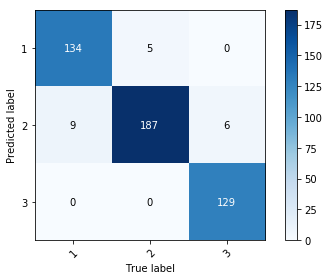

For Split: 3 , Accuracy Score:  0.9659574468085106
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       143
           2       0.96      0.96      0.96       192
           3       0.97      0.96      0.97       135

   micro avg       0.97      0.97      0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Confusion matrix, without normalization


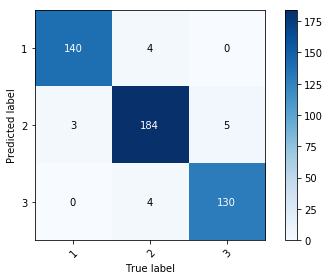

For Split: 4 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.94      0.95      0.94       143
           2       0.94      0.92      0.93       192
           3       0.96      0.97      0.96       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


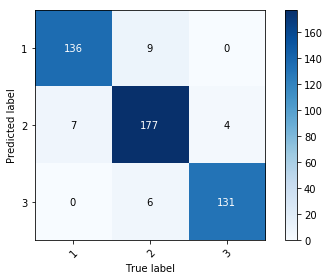

For Split: 5 , Accuracy Score:  0.9425531914893617
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       143
           2       0.92      0.94      0.93       192
           3       0.96      0.91      0.94       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.95      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


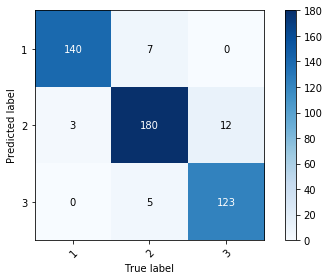

Mean Accuracy 0.9561954561846375
[0.9703389830508474, 0.9574468085106383, 0.9659574468085106, 0.9446808510638298, 0.9425531914893617, 0.9561954561846375, 'HSV,Random Forest']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.970339  0.957447  0.965957  0.944681  0.942553      0.956195   

             remarks  
0  HSV,Random Forest  


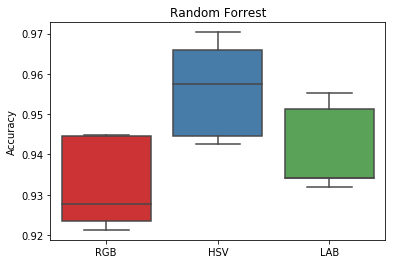

In [48]:
print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB=Random_Forrest(L, V,colorspace ="RGB")
print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))
save_csv(accuracy_score_list_RGB,'cross_validation_mean_value.csv','RGB,Random Forest')

print ("Random Forrest")
print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB=Random_Forrest(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_mean_value.csv','LAB,Random Forest')



print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV=Random_Forrest(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_mean_value.csv','HSV,Random Forest')


ax = sns.boxplot(x=['RGB','HSV','LAB'], y=[accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set(title= 'Random Forrest' ,ylabel='Accuracy')
plt.show()
filename = "bar_plot_mean_Random_Forest.png"
fig = ax.get_figure()
fig.savefig(filename)